In [1]:
import pandas as pd
# This is imported to gather the census data
import censusdata
import numpy as np

In [2]:
# This gets the states data ordered by states, specifically looking at the data gathered every 5 years (acs5) for the year
# of 2015
states = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2015)
# look at specifically california
states['California']

censusgeo((('state', '06'),))

In [3]:
# Now only grab from state 6 -- california
counties = censusdata.geographies(censusdata.censusgeo([('state', '06'), ('county', '*')]), 'acs5', 2015)
# Look for alameda county in california
counties['Alameda County, California']

censusgeo((('state', '06'), ('county', '001')))

In [4]:
# Here we are looking for labels related to household size -- we will use these later
censusdata.search('acs5', 2015, 'label', 'household size')

[('B25010_001E',
  'B25010.  Average Household Size of Occupied Housing Units by Tenure',
  'Average household size --!!Total:'),
 ('B25010_001M',
  'B25010.  Average Household Size of Occupied Housing Units by Tenure',
  'Margin Of Error For!!Average household size --!!Total:'),
 ('B25010_002E',
  'B25010.  Average Household Size of Occupied Housing Units by Tenure',
  'Average household size --!!Owner occupied'),
 ('B25010_002M',
  'B25010.  Average Household Size of Occupied Housing Units by Tenure',
  'Margin Of Error For!!Average household size --!!Owner occupied'),
 ('B25010_003E',
  'B25010.  Average Household Size of Occupied Housing Units by Tenure',
  'Average household size --!!Renter occupied'),
 ('B25010_003M',
  'B25010.  Average Household Size of Occupied Housing Units by Tenure',
  'Margin Of Error For!!Average household size --!!Renter occupied')]

In [5]:
# Downlod the things that pertain to our search result -- in this case the labels that we found above along with 
# the county and state we are looking at
berkeley_data = censusdata.download('acs5', 2015,
                            censusdata.censusgeo([('state', '06'),
                            ('county', '001'),
                            ('block group', '*')]),
          ['B25010_001E', 'B25010_001M', 'B25010_002E', 
           'B25010_002M', 'B25010_003E', 'B25010_003M'])

In [6]:
berkeley_data.head()

,B25010_001E,B25010_001M,B25010_002E,B25010_002M,B25010_003E,B25010_003M
"Block Group 4, Census Tract 4097, Alameda County, California: Summary level: 150, state:06> county:001> tract:409700> block group:4",3.53,0.95,4.15,1.17,3.06,1.31
"Block Group 1, Census Tract 4098, Alameda County, California: Summary level: 150, state:06> county:001> tract:409800> block group:1",2.49,0.60,2.28,0.48,3.00,1.62
"Block Group 2, Census Tract 4098, Alameda County, California: Summary level: 150, state:06> county:001> tract:409800> block group:2",2.80,0.50,3.24,1.02,2.58,0.59
"Block Group 3, Census Tract 4098, Alameda County, California: Summary level: 150, state:06> county:001> tract:409800> block group:3",2.61,0.75,2.87,0.90,1.75,0.50
"Block Group 1, Census Tract 4099, Alameda County, California: Summary level: 150, state:06> county:001> tract:409900> block group:1",2.56,0.57,2.52,0.64,3.05,0.87


Let us make the assumption that each tract will have the same amount of people in it (approximately true by google maps research), and that it would be fair to average each column to gather the average amount of people inside to be represetntative of what we should expect of alameda county.

In [7]:
# Gather all values that are non-negative or non-zero
berkeley_tracts = berkeley_data[berkeley_data.select_dtypes(include=[np.number]).ge(0).all(1)]

In [8]:
berkeley_tracts.agg('mean')

B25010_001E    2.841236
B25010_001M    0.429860
B25010_002E    2.920798
B25010_002M    0.637298
B25010_003E    2.917288
B25010_003M    0.734726
dtype: float64

For our case, I will just be using the total averages (001E, 002E, 003E) for our estimates. I will be using a poisson distribution to estimate the distribution of the household sizes.

In [9]:
# These labels are arbitarily assigned by the census data people -- you can find the description of this data below:
# https://www2.census.gov/programs-surveys/acs/tech_docs/code_lists/2015_ACS_Code_Lists.pdf
cols = ['B25010_001E', 'B25010_002E', 'B25010_003E']
sum_tracts = 0
for i in cols:
    sum_tracts += berkeley_tracts.agg('mean')[i]
average = sum_tracts/3

In [10]:
# What our estimate looks like
import matplotlib.pyplot as plt
# number of estimates found in the pdf averageabove for the population in berkeley
dist = s = np.random.poisson(average, 44978)
count, bins, ignored= plt.hist(dist,bins = [0,1,2,3,4,5,6,7,8,9,10,11,12] , density = True)
plt.show()

<Figure size 640x480 with 1 Axes>

(array([ 20.,  83., 168., 234., 201., 173.,  71.,  36.,  14.,   3.]),
 array([1.23 , 1.622, 2.014, 2.406, 2.798, 3.19 , 3.582, 3.974, 4.366,
        4.758, 5.15 ]),
 <BarContainer object of 10 artists>)

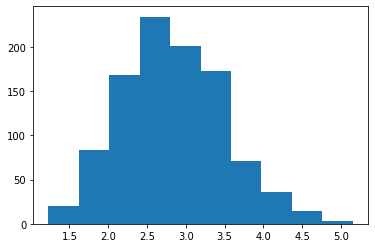

In [11]:
# Looking at the specific distributions of each block search
plt.hist(berkeley_tracts['B25010_001E'])

(array([114., 617., 232.,  32.,   6.,   0.,   0.,   1.,   0.,   1.]),
 array([ 1.07 ,  2.154,  3.238,  4.322,  5.406,  6.49 ,  7.574,  8.658,
         9.742, 10.826, 11.91 ]),
 <BarContainer object of 10 artists>)

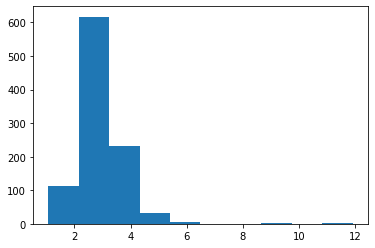

In [12]:
plt.hist(berkeley_tracts['B25010_002E'])

(array([232., 406., 247.,  92.,  20.,   4.,   0.,   1.,   0.,   1.]),
 array([ 1.11 ,  2.119,  3.128,  4.137,  5.146,  6.155,  7.164,  8.173,
         9.182, 10.191, 11.2  ]),
 <BarContainer object of 10 artists>)

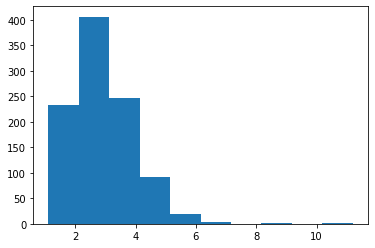

In [13]:
plt.hist(berkeley_tracts['B25010_003E'])

In [14]:
dist_tracts = np.concatenate([berkeley_tracts['B25010_001E'].to_numpy(),
                             berkeley_tracts['B25010_002E'].to_numpy(),
                             berkeley_tracts['B25010_003E'].to_numpy()])

(array([ 515., 1620.,  736.,  112.,   19.,    3.,    0.,    2.,    0.,
           2.]),
 array([ 1.07 ,  2.154,  3.238,  4.322,  5.406,  6.49 ,  7.574,  8.658,
         9.742, 10.826, 11.91 ]),
 <BarContainer object of 10 artists>)

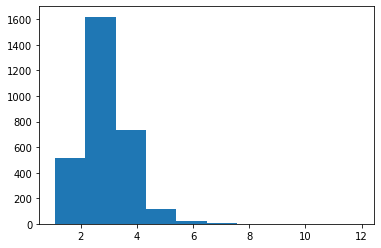

In [15]:
plt.hist(dist_tracts)

This distribution of household sizes in the tracts in Alameda County closely resembles that of a poission distribution. To make our simulation replicate this distribution of households, we will be pulling from a poission distribution to represent the household sizes in our randomly generated homes. The average variable represents the lambda we are using in our simulation for our poission distribution of demands in our Hash.Ai project.